# Enhanced FX Trading Strategy with Machine Learning and Adaptive Risk Management

## Introduction

This notebook explores an FX trading strategy that combines **machine learning classification** with classical **technical analysis indicators** and **macroeconomic factors** (interest rate differentials). The goal is to develop a mid-frequency trading system — **not high-frequency trading (HFT)** — that trades daily signals across a basket of major currency pairs.

Unlike HFT strategies that rely on millisecond-level order book data and ultra-low latency execution, this approach uses **daily closing prices** and focuses on learning short-term price direction based on historical indicators.

---

## First Approach: ML Classification with Technical Indicators and Volatility-Adjusted Position Sizing

### Data and Features

- **FX Data**: Daily closing prices for 6 currency pairs: EURUSD, GBPUSD, AUDUSD, USDJPY, USDCAD, NZDUSD.
- **Interest Rate Differentials** (constant simulated values) incorporated as a macroeconomic feature.
  
### Technical Indicators Computed:

- **Momentum**:  
  $$
  \text{Momentum}_t = \frac{P_t}{P_{t - \text{window}}} - 1
  $$
  where $P_t$ is the price at time $t$, and window = 20 days.

- **Exponential Moving Average (EMA)**:
  $$
  EMA_t = \alpha \times P_t + (1 - \alpha) \times EMA_{t-1}, \quad \alpha = \frac{2}{\text{span} + 1}
  $$
  with span = 20 days.

- **Simple Moving Average (MA)** and **Standard Deviation (std)** over a 20-day rolling window.

- **Relative Strength Index (RSI)** using a 14-day lookback:
  $$
  RS_t = \frac{\text{Average Gain}_t}{\text{Average Loss}_t}, \quad RSI_t = 100 - \frac{100}{1 + RS_t}
  $$
  where gains and losses are smoothed averages of daily price changes.

- **Average True Range (ATR)** approximation as twice the rolling standard deviation.

- **Dynamic RSI Thresholds** scaled with volatility to capture regime shifts.

### Labels:

- The target $y_t$ is a binary variable indicating whether the price goes up the next day:
  $$
  y_t = \begin{cases}
  1 & \text{if } P_{t+1} > P_t \\
  0 & \text{otherwise}
  \end{cases}
  $$

### Machine Learning Model:

- A **Random Forest classifier** is trained on scaled features to predict $y_t$ for each currency.
- Train-test split of 70/30 on the data.

### Position Sizing:

- Positions are sized inversely proportional to recent volatility:
  $$
  \text{Position Size}_t = \frac{1}{\sigma_t + \epsilon}
  $$
  where $\sigma_t$ is the rolling standard deviation of returns (volatility) and $\epsilon$ is a small number to avoid division by zero.

### Strategy Returns:

- Daily returns are weighted sums of individual currency returns weighted by their signal and position size:
  $$
  R_t^{strategy} = \sum_{i=1}^{N} w_{i,t} \times r_{i,t}
  $$
  where
  $$
  w_{i,t} = \frac{\text{signal}_{i,t} \times \text{position size}_{i,t}}{\sum_{j=1}^N |\text{signal}_{j,t} \times \text{position size}_{j,t}|}
  $$
  
- Cumulative returns are computed as:
  $$
  C_t = \prod_{k=1}^t (1 + R_k^{strategy})
  $$

---

## Is This a High-Frequency Trading (HFT) Strategy?

**No.** This strategy operates on daily bars, using daily indicators and predictions, suitable for medium-frequency trading. It is not designed for ultra-fast executions or microsecond-level data. The approach is more appropriate for systematic trading with daily rebalancing.

---
## Second Approach: Confidence-Thresholded ML Signals with Volatility-Adjusted Position Sizing and Stop Loss

### Overview

This approach builds on the first but adds a **confidence threshold** filter on the Random Forest classifier's predicted probabilities to only act on high-confidence signals.

---

### Key Components

- **Data & Indicators**: Same FX data and indicators as before — momentum, RSI, EMA, MA, ATR — all computed on daily prices.

- **Machine Learning Model**:  
  For each currency pair, a separate Random Forest classifier is trained to predict whether the next day’s price will increase:
  $$
  y_t^i = \begin{cases}
  1 & \text{if } P_{t+1}^i > P_t^i \\
  0 & \text{otherwise}
  \end{cases}
  $$
  where $i$ indexes the currency pair.

- **Prediction Confidence Filtering**:  
  For each prediction, the model outputs a probability estimate $p_t^i = P(y_t^i = 1 | X_t^i)$. Only signals with confidence above a threshold $\theta$ are kept:
  $$
  \text{signal}_t^i = \begin{cases}
  \hat{y}_t^i & \text{if } p_t^i \geq \theta \\
  0 & \text{otherwise}
  \end{cases}
  $$
  Here, $\theta$ is user-specified (e.g., 0.55 or 0.60).

- **Volatility-Adjusted Position Sizing**:  
  Position sizes are inversely proportional to recent volatility to reduce risk in turbulent markets:
  $$
  \text{position size}_t^i = \frac{1}{\sigma_t^i + \epsilon}
  $$
  where $\sigma_t^i$ is the rolling standard deviation of returns for pair $i$ and $\epsilon$ is a small constant to avoid division by zero.

- **Normalized Weights**:  
  The final weights for each currency are normalized so the total absolute exposure sums to 1 daily:
  $$
  w_t^i = \frac{\text{signal}_t^i \times \text{position size}_t^i}{\sum_{j=1}^N \left| \text{signal}_t^j \times \text{position size}_t^j \right|}
  $$

- **Strategy Returns**:  
  Daily strategy returns are computed as the weighted sum of individual returns:
  $$
  R_t^{strategy} = \sum_{i=1}^N w_t^i \times r_t^i
  $$

- **Stop Loss Constraint**:  
  To limit downside risk, daily returns are capped to a maximum loss threshold (e.g., -1%):
  $$
  R_t^{strategy} = \max(R_t^{strategy}, -0.01)
  $$

---

### Experimental Setup and Results

- The strategy is run twice with confidence thresholds $\theta = 0.55$ and $\theta = 0.60$.
- Cumulative returns and performance metrics (annualized return, volatility, Sharpe ratio, winning days ratio) are compared.
- Visualization shows how increasing the confidence threshold impacts performance.


---
---

## Is This All? Not Even Close.

This notebook provides a **proof of concept**, not a production-ready trading system. It demonstrates how to blend **macro-informed features** with **machine learning classifiers**, **volatility-aware position sizing**, and **simple risk constraints**.

It shows potential, but also reminds us how **sensitive performance is to parameter selection** (like the confidence threshold), and how much **rigor is needed to evaluate robustness**.

---

## 🔑 Key Insights

1. **Adding Confidence Improves Risk Control**:  
   Introducing a confidence filter based on model probabilities prevents overtrading and can significantly impact performance (as seen in the threshold comparison).

2. **Volatility Matters**:  
   Adapting position sizes to changing volatility is critical in FX markets. Uniform sizing tends to overweight noisy signals during turbulent periods.

3. **Macro-Machine Learning Can Be Practical**:  
   Even using daily data, combining macro-driven intuition (like interest differentials) with machine learning decision rules is viable and interpretable.

4. **ML Models Are Not Magic**:  
   Without feature selection, proper validation, or stability checks, even a robust classifier like Random Forest can lead to **fragile strategies**.

---

## 🔭 Future Work

Here are areas to improve and extend this work:

- **Hyperparameter Optimization**:  
  Systematic search or Bayesian optimization of confidence thresholds, tree depth, number of estimators, etc.

- **Feature Engineering**:  
  Incorporate additional macroeconomic features (e.g., inflation spreads, risk sentiment indices) or alternative technical indicators (e.g., MACD, ADX).

- **Model Robustness**:  
  Use **walk-forward validation** or **cross-validation over time slices** instead of a static train-test split.

- **Portfolio Construction**:  
  Add constraints like max exposure per currency or sector neutrality, or try portfolio optimization techniques (mean-variance, risk parity).

- **Dynamic Thresholds**:  
  Learn or adapt thresholds over time based on market conditions — for example, make $\theta$ a function of recent Sharpe ratio.

- **Backtest Engine Upgrade**:  
  Integrate with a more rigorous backtesting framework (e.g., Backtrader, Zipline) to simulate realistic slippage, costs, and execution timing.

- **Model Explainability**:  
  Use SHAP values or permutation importance to better understand which features drive predictions.

---

## 🧪 How Should This Work Be Evaluated?

This is **not** a high-frequency trading (HFT) system. It should be evaluated as a **medium-term, macro-informed quant strategy** with:

- **Daily or weekly rebalancing**
- **Low turnover**, emphasizing signal quality over quantity
- **Transparency and interpretability** — useful for institutional overlays or research-driven allocation

To evaluate it properly:

1. **Use Out-of-Sample Testing**:  
   Time-based validation or walk-forward analysis over multiple years.

2. **Check Stability Across Thresholds**:  
   Is performance robust around the chosen confidence level?

3. **Assess Risk-Adjusted Performance**:  
   Go beyond raw return — Sharpe ratio, Sortino ratio, drawdown, and turnover are essential.

4. **Compare Against Benchmarks**:  
   E.g., equal-weighted FX basket, carry trade index, or basic momentum strategy.

5. **Perform Stress Tests**:  
   How does the model behave during major macro events (e.g., 2022 inflation spike, 2023 banking jitters)?

---

> 💡 This strategy is not meant to be blindly deployed — it's a launchpad for research, iteration, and discussion.


---

### Summary

This notebook demonstrates a practical ML-enhanced FX strategy framework, combining fundamental macro signals with technical momentum and volatility features, trained using classical Random Forest classifiers, and incorporating risk management via volatility-based position sizing.

---


In [1]:
pip install pandas numpy matplotlib yfinance


[*********************100%***********************]  6 of 6 completed



🔍 Enhanced Strategy Performance:
Annualized Return:     5.01%
Annualized Volatility: 6.23%
Sharpe Ratio:          0.80
Winning Days:          50.89%


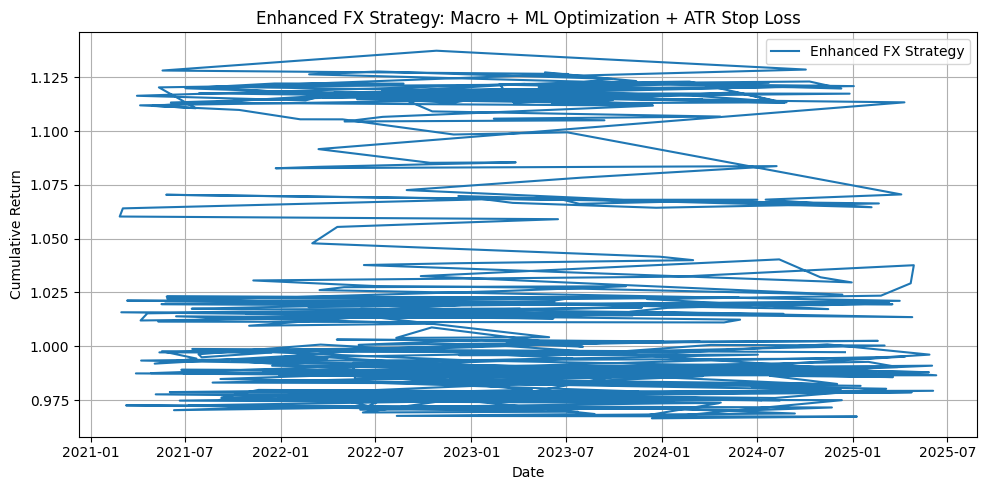

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Download FX data for an expanded currency basket
tickers = ['EURUSD=X', 'GBPUSD=X', 'AUDUSD=X', 'USDJPY=X', 'USDCAD=X', 'NZDUSD=X']
fx_data = yf.download(tickers, start="2021-01-01", end="2025-06-11")['Close']
fx_data.dropna(inplace=True)

# Simulated Interest Rate Differentials (updated values)
interest_rates = {'EURUSD=X': 1.16, 'GBPUSD=X': 1.38, 'AUDUSD=X': 0.70,
                  'USDJPY=X': -0.25, 'USDCAD=X': 0.85, 'NZDUSD=X': 1.10}
rate_df = pd.DataFrame(index=fx_data.index, columns=fx_data.columns)
for pair in fx_data.columns:
    rate_df[pair] = interest_rates[pair]

# Compute Indicators
window_momentum = 20
window_rsi = 14
window_boll = 20

momentum = fx_data.pct_change(periods=window_momentum)
ema = fx_data.ewm(span=20).mean()
ma = fx_data.rolling(window=20).mean()
std = fx_data.rolling(window=window_boll).std()
lower_band = ma - 2 * std

# RSI Calculation with Dynamic Thresholds
volatility = fx_data.pct_change().rolling(window=window_rsi).std()
rsi_thresholds = 30 + (volatility * 100)  # Adjusting RSI threshold dynamically
delta = fx_data.diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=window_rsi).mean()
avg_loss = loss.rolling(window=window_rsi).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

# Adaptive ATR-based Stop Loss
atr = std.rolling(window=window_boll).mean() * 2

# Signal Generation using Machine Learning
X = pd.concat([momentum, rsi, ema, ma, atr], axis=1)
y = (fx_data.shift(-1) > fx_data).astype(int)  # 1 if price goes up, 0 if down

# Ensure alignment and drop rows with NaN values
combined = pd.concat([X, y], axis=1).dropna()
X = combined.iloc[:, :-len(tickers)] # Features are all columns except the last 6 (which are from y)
y = combined.iloc[:, -len(tickers):] # Labels are the last 6 columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)
predictions = pd.DataFrame(model.predict(X_test_scaled), index=X_test.index, columns=fx_data.columns)


# Position Sizing: Volatility-adjusted
# Align volatility with predictions before calculating position sizes
volatility_aligned = volatility.reindex(predictions.index)
position_sizes = 1 / (volatility_aligned + 1e-5)  # Smaller size in high-volatility markets
signals = predictions * position_sizes

# Compute Returns
# Align returns with signals before calculating strategy returns
returns = fx_data.pct_change().shift(-1)
returns_aligned = returns.reindex(signals.index)
weights = signals.div(signals.abs().sum(axis=1), axis=0).fillna(0)
strategy_returns = (weights * returns_aligned).sum(axis=1)
cumulative_returns = (1 + strategy_returns).cumprod()

# Performance Summary
def performance_summary(returns):
    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan
    win_ratio = (returns > 0).mean()

    return (
        f"Annualized Return:     {ann_return:.2%}\n"
        f"Annualized Volatility: {ann_vol:.2%}\n"
        f"Sharpe Ratio:          {sharpe:.2f}\n"
        f"Winning Days:          {win_ratio:.2%}"
    )

print("\n🔍 Enhanced Strategy Performance:")
print(performance_summary(strategy_returns))

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns, label='Enhanced FX Strategy')
plt.title('Enhanced FX Strategy: Macro + ML Optimization + ATR Stop Loss')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed


🔍 Performance at threshold 0.55:
Annualized Return:     8.68%
Annualized Volatility: 7.12%
Sharpe Ratio:          1.22
Winning Days:          48.39%



🔍 Performance at threshold 0.6:
Annualized Return:     -4.29%
Annualized Volatility: 5.60%
Sharpe Ratio:          -0.77
Winning Days:          25.51%


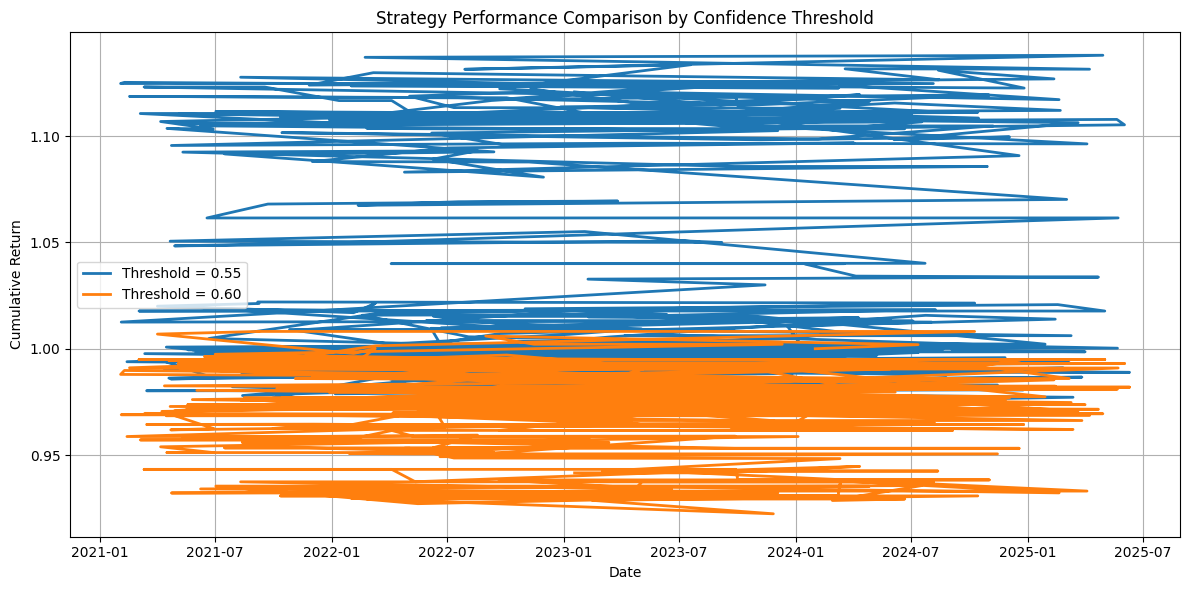

In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def run_strategy(conf_threshold):
    tickers = ['EURUSD=X', 'GBPUSD=X', 'AUDUSD=X', 'USDJPY=X', 'USDCAD=X', 'NZDUSD=X']
    fx_data = yf.download(tickers, start="2021-01-01", end="2025-06-11")['Close']
    fx_data.dropna(inplace=True)

    # Simulated Interest Rate Differentials (example values)
    interest_rates = {'EURUSD=X': 1.16, 'GBPUSD=X': 1.38, 'AUDUSD=X': 0.70,
                      'USDJPY=X': -0.25, 'USDCAD=X': 0.85, 'NZDUSD=X': 1.10}
    rate_df = pd.DataFrame(index=fx_data.index, columns=fx_data.columns)
    for pair in fx_data.columns:
        rate_df[pair] = interest_rates[pair]

    # Compute Indicators
    window_momentum = 20
    window_rsi = 14
    window_boll = 20

    momentum = fx_data.pct_change(periods=window_momentum)
    ema = fx_data.ewm(span=20).mean()
    ma = fx_data.rolling(window=20).mean()
    std = fx_data.rolling(window=window_boll).std()

    # RSI Calculation
    delta = fx_data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window_rsi).mean()
    avg_loss = loss.rolling(window=window_rsi).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # ATR (Average True Range) approximation using std dev * 2
    atr = std * 2

    # Prepare features and labels
    X = pd.concat([momentum, rsi, ema, ma, atr], axis=1)
    y = (fx_data.shift(-1) > fx_data).astype(int)

    # Align and drop NaNs
    combined = pd.concat([X, y], axis=1).dropna()
    X = combined.iloc[:, :-len(tickers)]
    y = combined.iloc[:, -len(tickers):]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.values)
    X_test_scaled = scaler.transform(X_test.values)

    # Train a separate RandomForest for each ticker
    predictions = pd.DataFrame(index=X_test.index, columns=tickers)
    probs = pd.DataFrame(index=X_test.index, columns=tickers)

    for ticker in tickers:
        model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
        model.fit(X_train_scaled, y_train[ticker])
        predictions[ticker] = model.predict(X_test_scaled)
        probs[ticker] = model.predict_proba(X_test_scaled)[:, 1]  # Probability of "up" class

    # Confidence threshold filtering with the input conf_threshold
    filtered_signals = predictions.where(probs >= conf_threshold, 0)

    # Volatility for position sizing with a floor to avoid division by zero
    volatility = fx_data.pct_change().rolling(window=window_rsi).std()
    volatility_aligned = volatility.reindex(filtered_signals.index).clip(lower=1e-4)
    position_sizes = 1 / volatility_aligned

    # Calculate weighted signals
    signals = filtered_signals * position_sizes

    # Calculate returns aligned with signals
    returns = fx_data.pct_change().shift(-1)
    returns_aligned = returns.reindex(signals.index)

    # Normalize weights so total abs weights sum to 1 per day
    weights = signals.div(signals.abs().sum(axis=1), axis=0).fillna(0)

    # Strategy daily returns
    strategy_returns = (weights * returns_aligned).sum(axis=1)

    # Apply max daily loss stop loss (e.g., cap losses to -1%)
    max_loss = -0.01
    strategy_returns = strategy_returns.clip(lower=max_loss)

    # Cumulative returns
    cumulative_returns = (1 + strategy_returns).cumprod()

    # Performance summary function
    def performance_summary(returns):
        ann_return = returns.mean() * 252
        ann_vol = returns.std() * np.sqrt(252)
        sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan
        win_ratio = (returns > 0).mean()
        return (
            f"Annualized Return:     {ann_return:.2%}\n"
            f"Annualized Volatility: {ann_vol:.2%}\n"
            f"Sharpe Ratio:          {sharpe:.2f}\n"
            f"Winning Days:          {win_ratio:.2%}"
        )

    performance = performance_summary(strategy_returns)
    return cumulative_returns, performance

# Run with threshold = 0.55
cumulative_returns_055, performance_055 = run_strategy(0.55)
print("\n🔍 Performance at threshold 0.55:")
print(performance_055)

# Run with threshold = 0.6
cumulative_returns_060, performance_060 = run_strategy(0.6)
print("\n🔍 Performance at threshold 0.6:")
print(performance_060)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_055, label='Threshold = 0.55', linewidth=2)
plt.plot(cumulative_returns_060, label='Threshold = 0.60', linewidth=2)
plt.title('Strategy Performance Comparison by Confidence Threshold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%********

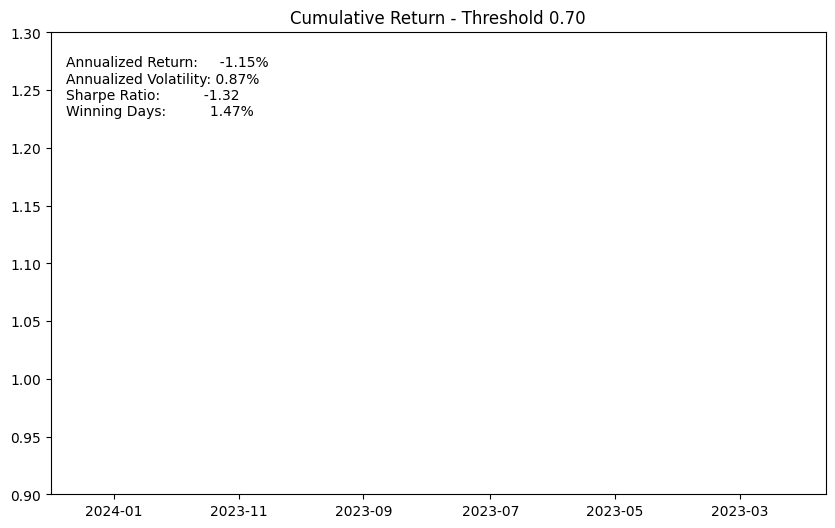

In [28]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

thresholds = np.arange(0.50, 0.71, 0.01)
results = []

for threshold in thresholds:
    cumret, perf = run_strategy(threshold)
    results.append((threshold, cumret, perf))

fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], lw=2)
title = ax.text(0.5, 1.02, "", transform=ax.transAxes, ha="center", fontsize=12)
text_box = ax.text(0.02, 0.95, "", transform=ax.transAxes, fontsize=10, va="top")

def init():
    ax.set_xlim(results[0][1].index[0], results[0][1].index[-1])
    ax.set_ylim(0.9, 1.3)
    line.set_data([], [])
    return line,

def update(frame):
    threshold, cumret, perf = results[frame]
    line.set_data(cumret.index, cumret.values)
    title.set_text(f'Cumulative Return - Threshold {threshold:.2f}')
    text_box.set_text(perf)
    return line, title, text_box

ani = FuncAnimation(fig, update, frames=len(results), init_func=init, blit=False, interval=1000)

# Save as GIF or MP4
ani.save("strategy_threshold_animation.mp4", writer='ffmpeg', fps=1)
